<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/02_pytorch_classification_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import torch
import torch

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Setup random seed
RANDOM_SEED = 42

## 1. Make a binary classification dataset with Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.


In [ ]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

X, y = make_moons(n_samples = 1000)
print(X[:5], y[:5])

[[ 0.40865509 -0.30641875]
 [ 1.203188   -0.47913974]
 [ 1.99839514  0.44336832]
 [ 0.01236095  0.34325463]
 [ 0.15291711 -0.0314608 ]] [1 1 1 1 1]


In [ ]:
# Turn data into a DataFrame
import pandas as pd

moons = pd.DataFrame({"x": X[:,0], "y": X[:,1], "label": y})
moons.head()

,x,y,label
0,0.408655,-0.306419,1
1,1.203188,-0.479140,1
2,1.998395,0.443368,1
3,0.012361,0.343255,1
4,0.152917,-0.031461,1


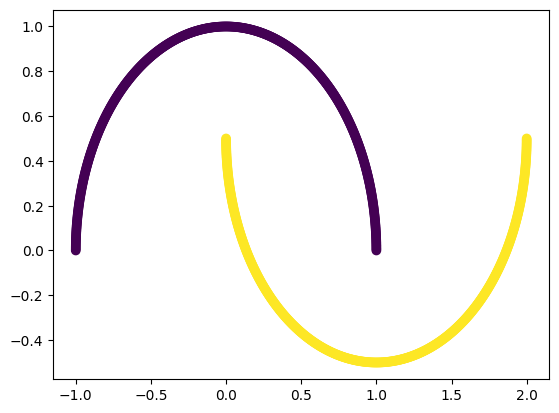

In [ ]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt

plt.scatter(moons['x'], moons['y'], c = moons['label'])
plt.show()

In [ ]:
# Turn data into tensors of dtype float
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

print(X_train[:5])

tensor([[ 0.0912,  0.9958],
        [-0.6015,  0.7989],
        [ 0.9509,  0.3096],
        [ 0.6458, -0.4352],
        [-0.7574,  0.6529]], device='cuda:0')


## 2. Build a model


In [ ]:
import torch
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Linear(in_features = 2, out_features = 32),
        nn.ReLU(),
        nn.Linear(in_features = 32, out_features = 32),
        nn.ReLU(),
        nn.Linear(in_features = 32, out_features = 1)
    )

  def forward(self, x):
    return self.layer_stack(x)

# Instantiate the model
model_0 = MoonModelV0().to(device)

## 3. Set-up loss function and optimizer

In [ ]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup optimizer to optimize model's parameters
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.05)

## 4. Create a training and testing loop


In [ ]:
# What's coming out of our model?
what_coming = model_0(X_train).squeeze()

# logits (raw outputs of model)
print("Logits:")
print(what_coming[:5])

# Prediction probabilities
print("Pred probs:")
print(torch.sigmoid(what_coming)[0:5])

# Prediction labels
print("Pred labels:")
print(torch.round(torch.sigmoid(what_coming))[:5])

Logits:
tensor([-0.2222, -0.1877, -0.1927, -0.1839, -0.1746], device='cuda:0',
       grad_fn=<SliceBackward0>)
Pred probs:
tensor([0.4447, 0.4532, 0.4520, 0.4542, 0.4565], device='cuda:0',
       grad_fn=<SliceBackward0>)
Pred labels:
tensor([0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SliceBackward0>)


In [ ]:
# Let's calculuate the accuracy using accuracy from TorchMetrics
!pip -q install torchmetrics # Colab doesn't come with torchmetrics
from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 27.5 MB/s eta 0:00:00


MulticlassAccuracy()

In [ ]:
torch.manual_seed(RANDOM_SEED)

# Setup epochs
epochs = 1000

# Loop through the data
for epoch in range(epochs):

  model_0.train()

  # 1. Forward pass (logits output)
  y_logits = model_0(X_train).squeeze()

  # Turn logits into prediction probabilities
  y_pred_prob = torch.sigmoid(y_logits)

  # Turn prediction probabilities into prediction labels
  y_pred = torch.round(y_pred_prob)

  # 2. Calculaute the loss
  loss = loss_fn(y_logits, y_train) # loss = compare model raw outputs to desired model outputs

  # Calculate the accuracy
  acc = acc_fn(y_pred, y_train.int()) # the accuracy function needs to compare pred labels (not logits) with actual labels

  # 3. Zero the gradients
  optimizer.zero_grad()

  # 4. Loss backward (perform backpropagation)
  loss.backward()

  # 5. Step the optimizer (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass (to get the logits)
    y_logits = model_0(X_test).squeeze()
    # Turn the test logits into prediction labels
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Caculate the test loss/acc
    test_loss = loss_fn(y_logits, y_test)
    test_acc = acc_fn(y_pred, y_test)

  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
    print(f"Test accuracy:{test_acc}    Test loss:{test_loss}")


Test accuracy:0.4699999988079071    Test loss:0.6999844908714294
Test accuracy:0.824999988079071    Test loss:0.3933848738670349
Test accuracy:0.8849999904632568    Test loss:0.28070366382598877
Test accuracy:0.8949999809265137    Test loss:0.24766935408115387
Test accuracy:0.9049999713897705    Test loss:0.22590549290180206
Test accuracy:0.9150000214576721    Test loss:0.2060019075870514
Test accuracy:0.9150000214576721    Test loss:0.18569648265838623
Test accuracy:0.9200000166893005    Test loss:0.16430015861988068
Test accuracy:0.9399999976158142    Test loss:0.14116090536117554
Test accuracy:0.9549999833106995    Test loss:0.1170400008559227


## 5. Make predictions

In [ ]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

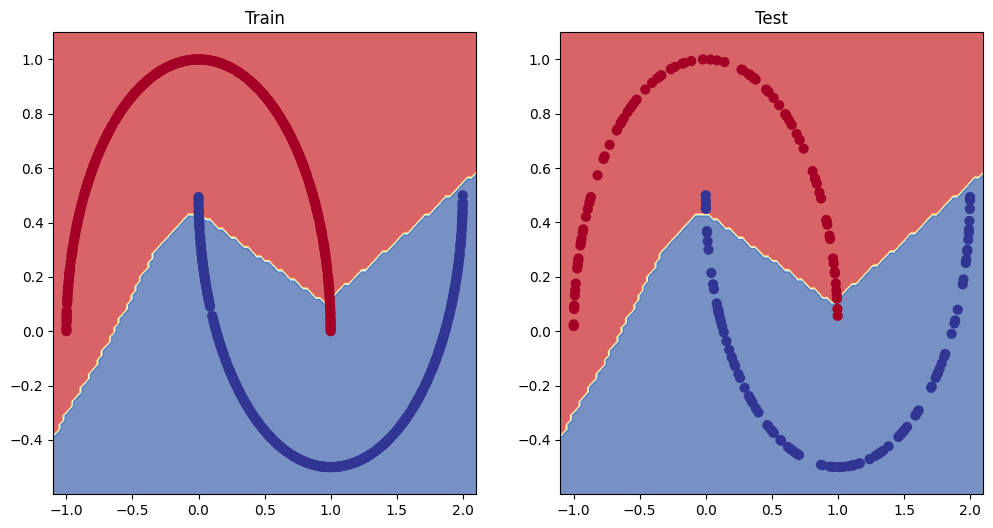

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.


In [ ]:
# Create a straight line tensor
X_new = torch.arange(-5, 5, 0.1)
X_new[:5]

tensor([-5.0000, -4.9000, -4.8000, -4.7000, -4.6000])

In [ ]:
# Test torch.tanh() on the tensor and plot it
y_new = torch.tanh(X_new)
y_new[:5]

tensor([-0.9999, -0.9999, -0.9999, -0.9998, -0.9998])

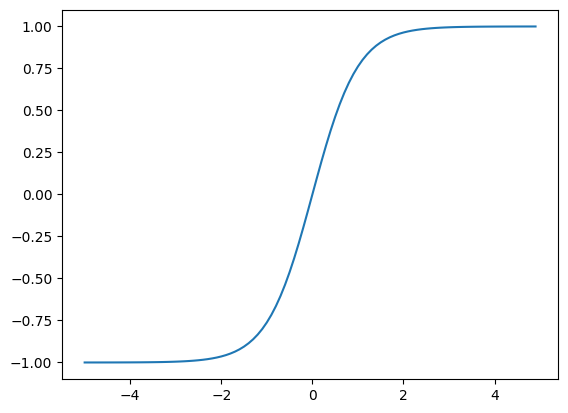

In [ ]:
# Replicate torch.tanh() and plot it
plt.plot(X_new, y_new)
plt.show()

## 7. Create a multi-class dataset using the [spirals data creation function from CS231n](https://cs231n.github.io/neural-networks-case-study/)


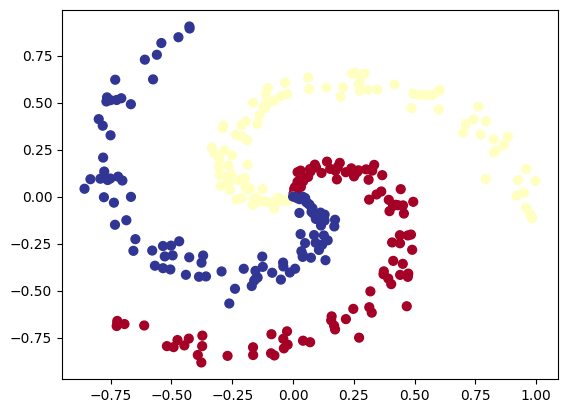

In [ ]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [ ]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)


In [ ]:
# Let's calculuate the accuracy for when we fit our model
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes=3).to(device)
acc_fn

MulticlassAccuracy()

In [ ]:

# Create model by subclassing nn.Module
class ModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Linear(in_features = 2, out_features = 128),
        nn.ReLU(),
        nn.Linear(in_features = 128, out_features = 128),
        nn.ReLU(),
        nn.Linear(in_features = 128, out_features = 3)
    )
  def forward(self, x):
    return self.layer_stack(x)


# Instantiate model and send it to device
model_1 = ModelV1().to(device)

In [ ]:
# Print out first 10 untrained model outputs (forward pass)
y_logits = model_1(X_train).squeeze()
print("Logits:")
print(y_logits[:5])

print("Pred probs:")
y_pred_probs = torch.softmax(y_logits, dim = 1).squeeze()
print(y_pred_probs[0:5])

print("Pred labels:")
y_pred = torch.argmax(y_pred_probs, dim = 1)
print(y_pred[:5])


Logits:
tensor([[-5.9794e-02,  1.4641e-01, -4.2076e-02],
        [-8.4110e-02,  1.5011e-01, -8.5683e-02],
        [-2.4797e-02,  1.2924e-01, -1.0976e-02],
        [-7.7222e-05,  6.4384e-02, -8.8124e-02],
        [ 2.6390e-02,  9.1497e-02, -3.2807e-02]], device='cuda:0',
       grad_fn=<SliceBackward0>)
Pred probs:
tensor([[0.3080, 0.3785, 0.3135],
        [0.3065, 0.3874, 0.3060],
        [0.3144, 0.3668, 0.3188],
        [0.3353, 0.3576, 0.3071],
        [0.3322, 0.3546, 0.3132]], device='cuda:0', grad_fn=<SliceBackward0>)
Pred labels:
tensor([1, 1, 1, 1, 1], device='cuda:0')


In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(), lr = 0.05)

In [ ]:
# Build a training loop for the model
epochs = 1000
# Loop over data
for epoch in range(epochs):

  ## Training
  model_1.train()
  # 1. Forward pass
  y_pred_logit = model_1(X_train).squeeze()
  y_train_prob = torch.argmax(torch.softmax(y_pred_logit, dim = 1).squeeze(), dim = 1)

  # 2. Calculate the loss
  loss = loss_fn(y_pred_logit, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    y_test_logits = model_1(X_test).squeeze()
    y_test_prob = torch.argmax(torch.softmax(y_test_logits, dim = 1).squeeze(), dim = 1)

    # 2. Caculate loss and acc
    loss_test = loss_fn(y_test_logits, y_test).squeeze()
    acc_test = acc_fn(y_test_prob, y_test.int())

  # Print out what's happening every 100 epochs
    # Print out what's happening every 100 epochs
    if epoch % 100 == 0:
      print(f"Test accuracy:{acc_test}    Test loss:{loss_test}")

Test accuracy:0.5166666507720947    Test loss:0.8174485564231873
Test accuracy:1.0    Test loss:0.0005171403172425926
Test accuracy:1.0    Test loss:0.0001205400621984154
Test accuracy:1.0    Test loss:4.244830779498443e-05
Test accuracy:1.0    Test loss:1.2176078598713502e-05
Test accuracy:1.0    Test loss:1.2418334335961845e-05
Test accuracy:1.0    Test loss:9.333439265901688e-06
Test accuracy:1.0    Test loss:7.780016858305316e-06
Test accuracy:1.0    Test loss:8.38389496493619e-06
Test accuracy:1.0    Test loss:5.934396085649496e-06


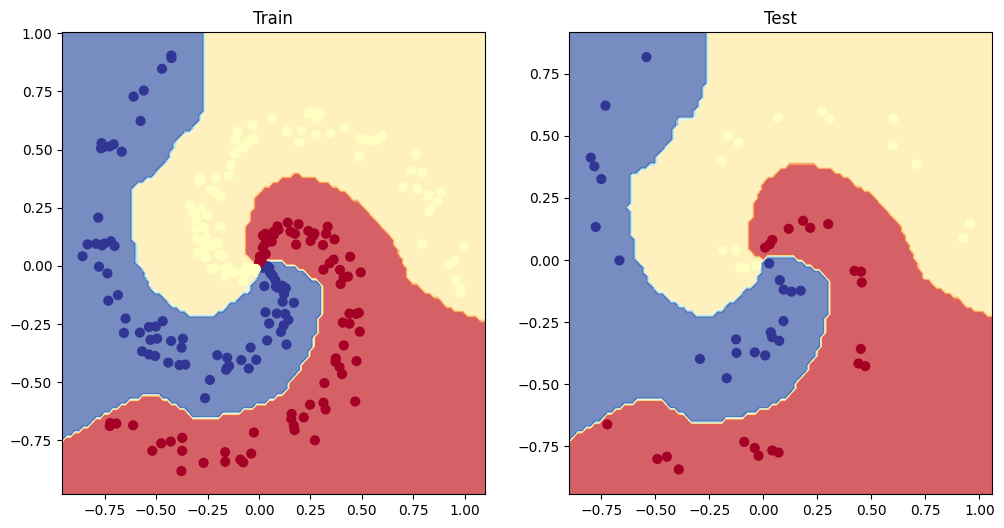

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)